<a href="https://colab.research.google.com/github/fgith/data-science/blob/main/deep-learning/computer-vision/finger_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers as tfl
import os
import cv2
from sklearn import preprocessing
from pathlib import Path
from PIL import Image

In [2]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list

In [4]:
!kaggle datasets download -d koryakinp/fingers

100% 362M/363M [00:02<00:00, 176MB/s]
100% 363M/363M [00:02<00:00, 149MB/s]


In [ ]:
!unzip fingers.zip

In [ ]:
os.getcwd()
print(os.name)
os.listdir()

posix


['.config',
 'fingers.zip',
 'test',
 'train',
 'fingers',
 'kaggle.json',
 'sample_data']

In [7]:
train_set_path = []
train_set_label = []

train_base = "../content/fingers/train/"

for filename in os.listdir(train_base):
    
    train_set_label.append(filename.split('.')[0][-2:])
    train_set_path.append(train_base+filename)
    

print("Number of training set examples: ", len(train_set_path))

test_set_path = []
test_set_label = []

test_base = "../content/fingers/test/"

for filename in os.listdir(test_base):
    
    test_set_label.append(filename.split('.')[0][-2:])
    test_set_path.append(test_base+filename)
    

print("Number of test set examples: ", len(test_set_path))

Number of training set examples:  18000
Number of test set examples:  3600


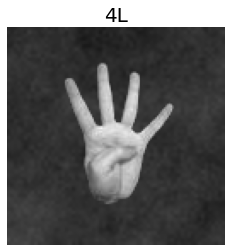

In [8]:
# checking train path
x=0
image = cv2.imread(train_set_path[x]) 

# the first image bleongs to clean directory under train
plt.imshow(image)
plt.title(train_set_label[x], fontsize = 20)
plt.axis('off')
plt.show()

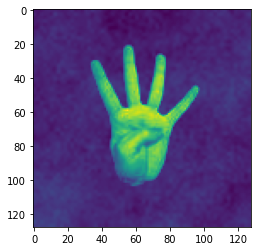

In [9]:
im = Image.open(train_set_path[x])
plt.imshow(im);

In [11]:
X_train = []
X_test = []

# reading images for train data
for path in train_set_path:
    
    image = cv2.imread(path)
    # try:        
    #   image =  cv2.resize(image, (64,64))    
    # except:
    #   break
    X_train.append(image)
    
# reading images for test data
for path in test_set_path:
    
    image = cv2.imread(path)        
    # try:   
    #   image =  cv2.resize(image, (64,64))
    # except:
    #   break  
    X_test.append(image)

X_test = np.array(X_test)
X_train = np.array(X_train)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(np.array(train_set_label).shape)

(18000, 128, 128, 3)
(3600, 128, 128, 3)
(18000,)


In [13]:
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(train_set_label)
y_test = label_encoder.fit_transform(test_set_label)

if len(np.unique(y_train)) == len(np.unique(y_test)):
  print("Number of classes: ", len(np.unique(y_train)))
  num_classes = len(np.unique(y_train))


Number of classes:  12


In [14]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [15]:
print("Categorical values for y_train:\n", y_train.shape)
# df = pd.DataFrame(y_train) 
# df

Categorical values for y_train:
 (18000, 12)


In [16]:
def convolutional_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    Z1 = tfl.Conv2D(filters= 8 , kernel_size= 4 , strides= 1 , padding='same')(input_img)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size=8, strides=8, padding='same')(A1)
    Z2 = tfl.Conv2D(filters= 16 , kernel_size= 2 , strides= 1 , padding='same')(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size=4, strides=4, padding='same')(A2)
    F =  tfl.Flatten()(P2)
    outputs =  tfl.Dense(units=12, activation='softmax')(F)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [17]:
conv_model = convolutional_model((128, 128, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       392       
                                                                 
 re_lu (ReLU)                (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        528       
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 16)        0         
                                                             

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
282/282 [==============================] - 123s 434ms/step - loss: 3.2314 - accuracy: 0.6262 - val_loss: 0.2857 - val_accuracy: 0.9203
Epoch 2/5
282/282 [==============================] - 113s 402ms/step - loss: 0.1746 - accuracy: 0.9459 - val_loss: 0.1335 - val_accuracy: 0.9653
Epoch 3/5
282/282 [==============================] - 115s 406ms/step - loss: 0.0807 - accuracy: 0.9749 - val_loss: 0.0753 - val_accuracy: 0.9792
Epoch 4/5
282/282 [==============================] - 114s 403ms/step - loss: 0.0425 - accuracy: 0.9876 - val_loss: 0.0456 - val_accuracy: 0.9853
Epoch 5/5
282/282 [==============================] - 114s 403ms/step - loss: 0.0271 - accuracy: 0.9916 - val_loss: 0.0311 - val_accuracy: 0.9894


In [ ]:
conv_model.evaluate(X_test, y_test)

113/113 [==============================] - 10s 86ms/step - loss: 0.0139 - accuracy: 0.9942


[0.013921840116381645, 0.9941666722297668]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

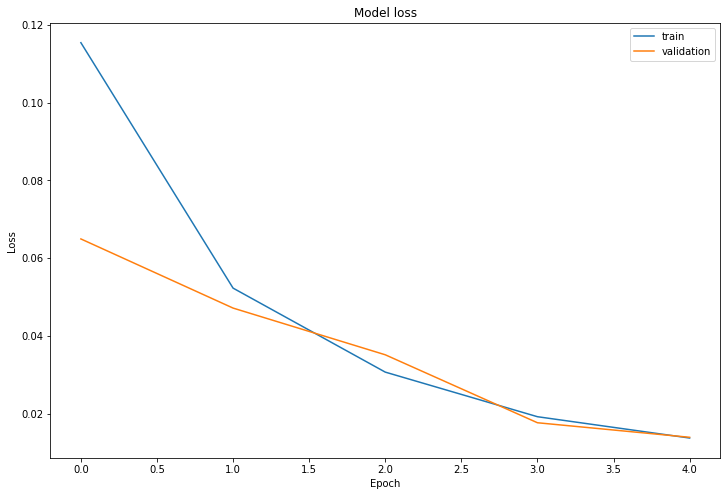

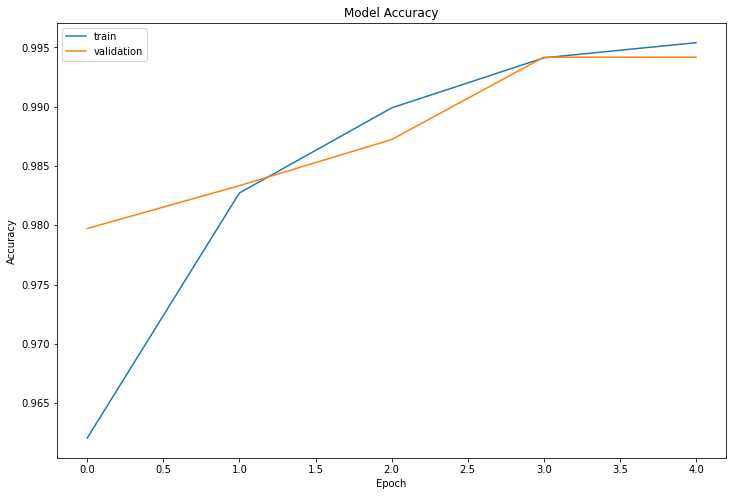

In [ ]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')